In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2

/usr/lib/python2.7/dist-packages/pkg_resources/__init__.py:1224: UserWarning: /home/brendan/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


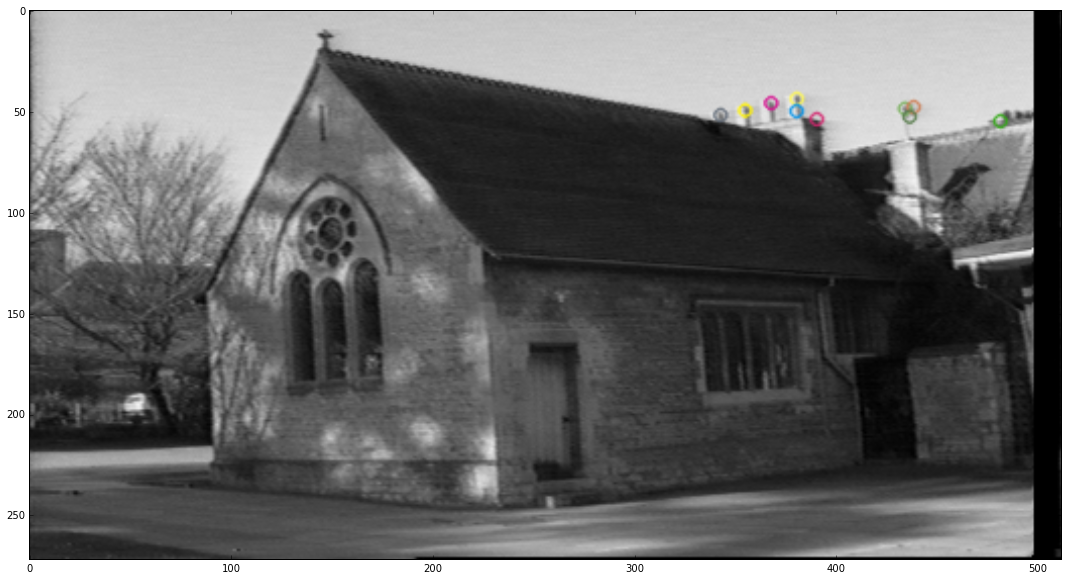

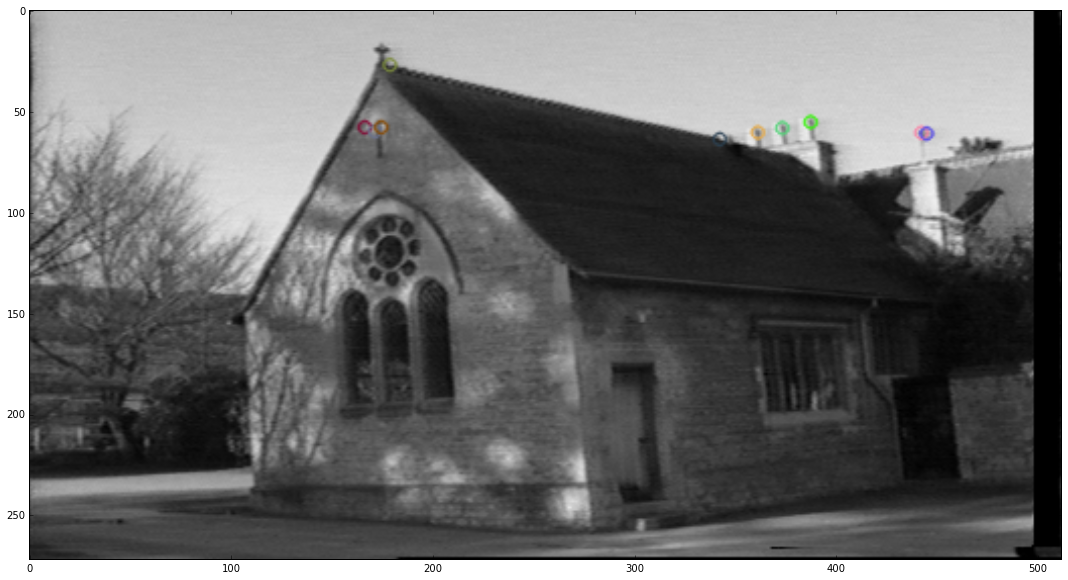

In [11]:
def extract_features(img):
    brisk=cv2.BRISK()
    kps,descs=brisk.detectAndCompute(img,None)
    return (kps,descs)

features1, feat1 = extract_features(pic1)
img1=cv2.drawKeypoints(pic1,features1[:10])
f1=plt.figure()
f1.set_size_inches(18.5, 10.5)
plt.imshow(img1, cmap = "Greys_r")

features2, feat2 = extract_features(pic2)
img2=cv2.drawKeypoints(pic2,features2[:10])
f2=plt.figure()
f2.set_size_inches(18.5, 10.5)
plt.imshow(img2, cmap = "Greys_r")

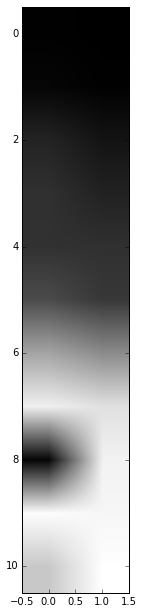

In [13]:
def match_kp(descs1,descs2):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(descs1, descs2, 2)
    matches = []
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * .75:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    return matches

matched = match_kp(feat1, feat2)

f1=plt.figure()
f1.set_size_inches(18.5, 10.5)
plt.imshow(matched, cmap = "Greys_r")
